# 자연어 시퀀스 레이블링

네이버 영화 리뷰 데이터를 이용해서 긍부정 분류를 해봅시다.

각 리뷰마다 해당 리뷰가 긍정인 경우 1, 부정인 경우 0으로 표기되어 있습니다.

해당 데이터 활용하여 긍부정 분류를 시연해봅시다.

## 패키지 설치

- pandas
- numpy
- matplotlib
- python-mecab-ko
- tqdm
- scikit-learn
- gensim

In [1]:
%pip install pandas numpy matplotlib python-mecab-ko tqdm scikit-learn gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from mecab import MeCab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
from gensim.models.word2vec import Word2Vec

# 데이터 로드하기

In [3]:
# 온라인에서 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x24e43776530>)

In [4]:
# 파일에서 로드하기
train_data = pd.read_table("ratings_train.txt")
test_data = pd.read_table("ratings_test.txt")

In [5]:
print("훈련용 리뷰 개수:", len(train_data))
train_data.head()

훈련용 리뷰 개수: 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


이 데이터는 id, document, label 열로 이루어져 있습니다.

document에 대한 긍,부정 열이 label입니다. label은 긍정=1, 부정=0으로 이루어져 있으며 이진 분류 모델을 예측해야 하는 값입니다.

# 데이터 정제하기

먼저 텍스트 파일을 전처리해봅시다. 한글과 공백만 남기고 나머지 문자를 제거해봅시다.

In [6]:
def extract_ko(text):
    # 예외(ex. Null) 값 무시
    if not isinstance(text, str):
        return text
    # 정규표현식
    return re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)

train_data["document"] = train_data["document"].apply(extract_ko)


train_data.head(5)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


중복 데이터를 제거해봅시다. 먼저, nunique() 메소드로 중복 데이터가 있는지 확인해봅시다. nunique()는 고유한(unique) 데이터의 개수(n)를 반환합니다 (null값은 제외합니다). 

In [7]:
train_data["document"].nunique()

143682

총 리뷰 데이터가 150,000개인데, 해당 출력값이 143,682라는 것은 중복된 데이터가 약 6,400개 있다는 것입니다. 해당 데이터들을 제거해봅시다.

In [8]:
train_data = train_data.drop_duplicates(subset=["document"])

print("총 훈련 샘플 수: ", len(train_data))

총 훈련 샘플 수:  143683


리뷰중에 Null 값이 있는지 확인해봅시다.

In [9]:
train_data.isnull().values.any()

True

`True`가 나온다면 Null 값을 가진 샘플이 있다는 뜻입니다. 어느 열, 어느 행에 있는지 확인해봅시다.

In [10]:
# 어느 열에 몇개 있는지
print(train_data.isnull().sum())

# 해당 행 출력
train_data.loc[train_data.isnull().any(axis=1)]

id          0
document    1
label       0
dtype: int64


,id,document,label
25857,2172111,NaN,1


Null 값을 가진 샘플을 제거합시다.

In [11]:
# Null 샘플 제거
train_data = train_data.dropna(how="any")


# 확인
print(train_data.isnull().values.any())

False


또한, 원본 데이터 또는 전처리된 데이터에서 빈 문자열 `""` 또는 공백만이 있는 데이터가 생성될 수도 있습니다. 이를 제거해봅시다.

In [12]:
# 양 옆 공백을 제거했을 때 (strip) 빈 문자열이 나오는 데이터의 인덱스 리스트 
train_data[train_data["document"].str.strip()==""].index

Index([   404,    470,    584,   1549,   2295,   3563,   5136,   5221,  13927,
        16282,  22857,  23191,  28285,  33513,  35284,  36412,  62651,  67646,
        82158, 130342, 132697, 148566],
      dtype='int64')

In [13]:
# 해당하는 행 제거 drop()
train_data = train_data.drop(
    train_data[train_data["document"].str.strip()==""].index
)

print("전처리 후 총 훈련 샘플 수: ", len(train_data))

전처리 후 총 훈련 샘플 수:  143660


테스트 데이터에서 똑같은 과정을 합니다

In [14]:
test_data["document"] = test_data["document"].apply(extract_ko)
test_data = test_data.drop_duplicates(subset=["document"])
test_data = test_data.dropna(how="any")
test_data = test_data.drop(
    test_data[test_data["document"].str.strip()==""].index
)

# 토큰화 (형태소 분할)

In [15]:
# 불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

tokenizer = MeCab()

train_len = len(train_data['document'])
test_len = len(test_data['document'])

tokenized_train=[]
for i, sentence in enumerate(train_data['document']):
    temp = tokenizer.morphs(sentence) # 토큰화
    temp = [tok for tok in temp if not tok in stopwords] #불용어 제거
    tokenized_train.append(temp)
    print(f"[({i}\{train_len})]\r", end="")
print("\ntrain data done.")

tokenized_test=[]
for i, sentence in enumerate(test_data['document']):
    temp = tokenizer.morphs(sentence) # 토큰화
    temp = [tok for tok in temp if not tok in stopwords] #불용어 제거
    tokenized_test.append(temp)
    print(f"[({i}\{test_len})]\r", end="")
print("\ntest data done.")

[(143659\143660)]
train data done.
[(48402\48403)]
test data done.


# 단어 집합 생성 및 토큰 임베딩

gensim 라이브러리를 이용하여 단어 집합과 Word2Vec을 동시에 만들어봅시다.

In [16]:
emb_size = 128

word2vec = Word2Vec(
    sentences=tokenized_train, # 학습 데이터
    vector_size=emb_size, # 토큰 잠재벡터 크기
    window=5, # 중심단어에서 이웃단어를 선택하는 범위. 
    min_count=5, # 이 빈도보다 적게 나타나는 단어는 제외함
    workers=4, # 멀티쓰레딩 쓰레드 개수. 
    sg=1 # 0 = CBOW, 1=skip-gram
)

# 사전을 형성합니다. 토큰 -> 인덱스
word2index = {"<unk>": 0, "<pad>": 1}
word2index.update({k: word2vec.wv.key_to_index[k]+2 for k in word2vec.wv.key_to_index})
# 인덱스 -> 토큰
index2word = list(word2index.keys())
# 각 토큰에 대한 벡터를 저장한 행렬입니다.
# <unk> 토큰과 <pad>에 대해서 무작위 벡터를 추가해봅시다.
embedding_w = word2vec.wv.vectors

unk_pad_emb = np.random.normal(0, 1/np.sqrt(emb_size), size=[2, emb_size])
embedding_w = np.concatenate([unk_pad_emb, embedding_w], axis=0)

## 분할된 텍스트에서 인덱스로 변환하는 함수

In [17]:
def text_to_sequences(x_data, word2index):
    # 입력이 배치로 들어오지 않는 경우를 예외처리
    if isinstance(x_data[0], str):
        x_data = [x_data]

    encoded_x_data = []
    for sent in x_data:
        encoded_x_data.append(
            [word2index[tok] if tok in word2index else word2index["<unk>"] for tok in sent]
        )
    return encoded_x_data


def sequences_to_text(x_data, index2word):
    # 입력이 배치로 들어오지 않는 경우를 예외처리
    if isinstance(x_data[0], int):
        x_data = [x_data]

    encoded_x_data = []
    for sent in x_data:
        encoded_x_data.append(
            [index2word[idx] for idx in sent]
        )
    return encoded_x_data

encoded_train = text_to_sequences(tokenized_train, word2index)
encoded_test = text_to_sequences(tokenized_test, word2index)

In [18]:
tokenized_train[0], encoded_train[0]

(['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 [20, 58, 885, 26, 206, 7, 21, 694])

# 패딩

In [19]:
max_len = max([len(l) for l in encoded_train]+[len(l) for l in encoded_test])

print(f"최대 길이: {max_len}")

def pad_truncate(x_data, max_len, pad_idx=word2index["<pad>"]):
    """max len보다 짧으면 패딩하고 길면 자릅니다."""
    res = np.ones([len(x_data), max_len], dtype=int) * pad_idx
    for i in range(len(x_data)):
        end_point = min(len(x_data[i]), max_len)
        res[i][:end_point] = x_data[i][:end_point]
    return res

encoded_train = pad_truncate(encoded_train, max_len)
encoded_test = pad_truncate(encoded_test, max_len)


최대 길이: 74


# 학습, 검증, 테스트 데이터

학습하는 동안 우리의 모델이 제대로 학습되었는지 평가하기 위해, 학습 데이터에서 일부를 떼어내어 검증(validation) 데이터 준비합니다.

학습된 모델의 중간 평가 및 학습의 중단도 학습의 일부이기 때문에, 검증 데이터를 테스트 데이터로 대체하거나 추출하는 실수는 하지 않도록 합니다.



In [20]:
X_train = encoded_train
X_test = encoded_test
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# 검증데이터 생성
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [21]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.264%
긍정 리뷰 = 49.736%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.265%
긍정 리뷰 = 49.735%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.83%
긍정 리뷰 = 50.17%


In [22]:
print('첫번째 샘플의 길이 :', len(X_train[0]))
print('첫번째 샘플 :', X_train[0])

첫번째 샘플의 길이 : 74
첫번째 샘플 : [   6  212  544 2016 1977  576  166    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1]


# LSTM을 이용한 영화 리뷰 분류

우리가 사용하게될 신경망, LSTM에 들어가기 앞서 그 대분류인 순환신경망에 대해서 먼저 알아봅시다.

## 순환신경망 (RNN)

순환신경망은 입력 또는 출력에 차례(=step)가 있고, 차례로 입/출력을 처리할 때 자기 자신의 상태를 다음 차례의 자기 자신에게 전달하게끔 한 신경망입니다.

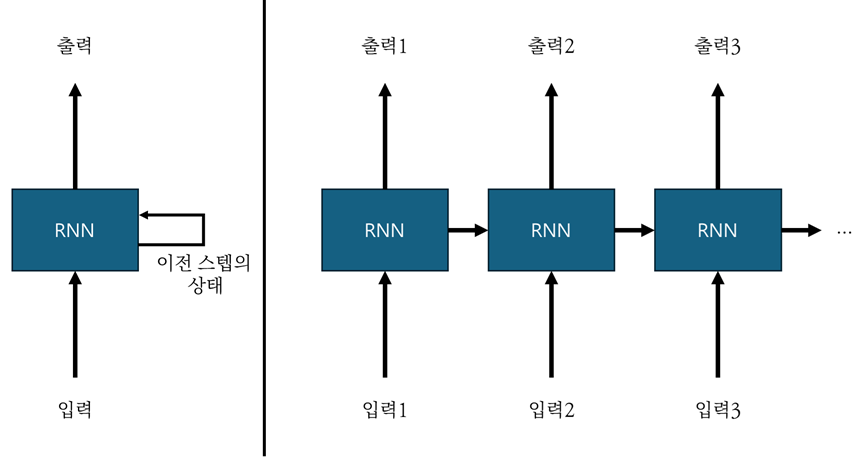

전달된 자기 자신의 상태를 이용하여, RNN은 과거의 정보를 추가적으로 가공하거나 활용하여 이후에 있을 출력 예측에 활용합니다.

이러한 특징 때문에 순환신경망은 시간에 따른 데이터 (시계열데이터)나 텍스트와 같은 순서가 있는 데이터를 다루는데 적합한 구조입니다.

자연어 처리의 경우, 각 스텝의 입력은 그 토큰에 대응하는 벡터가 됩니다.

## LSTM

Long Short-term Memory(LSTM, 장단기메모리)는 순환신경망(RNN)의 일종으로,

장기기억과 단기기억을 분리하여 시간에 감에 따라서 전달하는 신경망입니다.

<br/>
<br/>


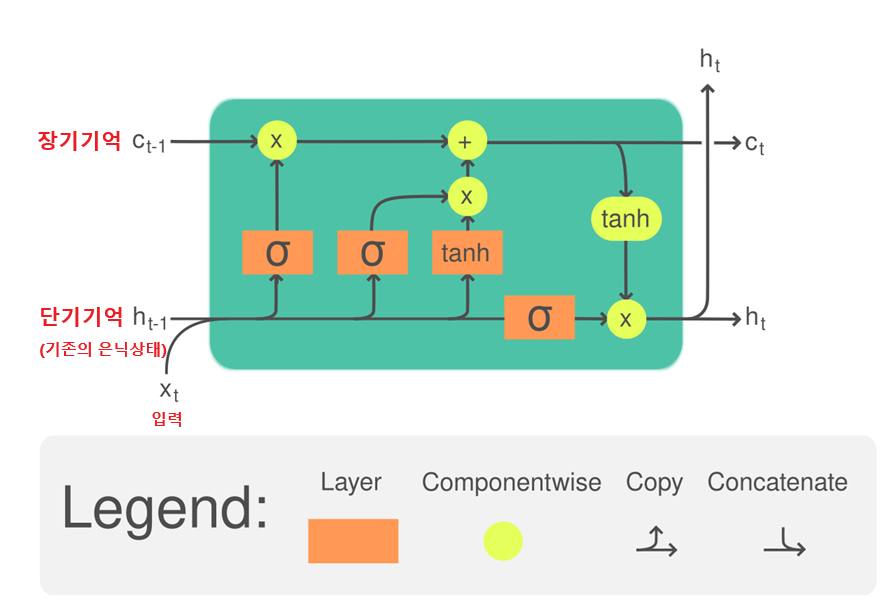

(출처: [Guillaume Chevalier](https://guillaume-chevalier.com/)의 LSTM 그림.)

기존 RNN에서는 멀리 떨어진 차례간의 정보전달이 잘 안되고 학습이 더딘 문제가 있었으며

이를 해결하고자 장기기억 상태를 가진 LSTM이 탄생하게 되었습니다.

아래 예제부터는 이 LSTM을 사용하여 영화 리뷰에 대한 긍정과 부정을 분류합니다.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 사용 장치 설정, gpu (cuda) or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


데이터를 Tensor 형으로 변환합니다.

In [24]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
X_test = torch.tensor(X_test)

y_train = torch.tensor(y_train)
y_valid = torch.tensor(y_valid)
y_test = torch.tensor(y_test)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=1)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)

print(f"총 학습 배치의 수 : {len(train_dataloader)}")

총 학습 배치의 수 : 3592


## LSTM 모델 구축 

텍스트 분류를 위한 LSTM 모델의 구조는 다음과 같습니다.

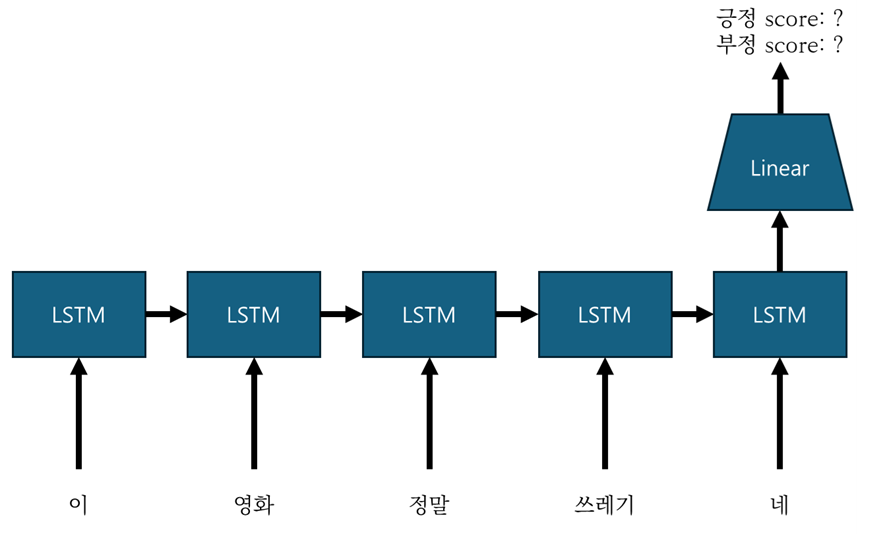

In [25]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, word_emb=None, pad_idx=None):
        """
        args:
            vocab_size: 사전에 들어간 단어의 개수입니다.
            embedding_dim: 워드 임베딩의 차원 크기입니다.
            hidden_dim: 신경망 은닉층 차원 크기입니다.
            output_dim: 최종 출력 차원 크기입니다. 분류의 경우, 레이블의 개수가 됩니다.
            word_emb: 미리 학습된 단어 임베딩을 전달하여 이로 초기화합니다.
            pad_idx: 패딩의 index입니다. 지정시 해당 index의 임베딩은 학습이 이루어지지 않습니다.
        """
        super(TextClassifier, self).__init__()
        self.pad_idx = pad_idx
        # 워드 임베딩
        if word_emb is not None:
            embedding_dim = word_emb.shape[1]
            # 정규화
            word_emb = (word_emb - np.mean(word_emb, axis=0)) / (np.std(word_emb, axis=0) + 1e-6)
            self.embedding = nn.Embedding.from_pretrained(torch.tensor(word_emb).to(torch.float), padding_idx=pad_idx)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # Feed-forword
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        bsz, seq_len = x.shape
        embedded = self.embedding(x) # (b, l, emb_dim)
        if self.pad_idx is not None:
            # padding 토큰의 마지막 위치를 찾습니다.
            pad_mask = (x == self.pad_idx)
            pad_idx = torch.argmax(pad_mask.to(torch.int32), dim=1)
            # padding 토큰이 없는 경우 (pad_idx==0) 마지막 자리를 가리키도록 예외처리를 합니다
            pad_idx[pad_idx==0] = seq_len
            last_idx = pad_idx - 1
        else:
            last_idx = seq_len - 1

        # LSTM은 (hidden state, cell state) 튜플을 반환합니다.
        # lstm_out: (b, l, h_dim)
        # hidden: (1, b, h_dim), cell: (1, b, h_dim)
        
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # padding 토큰이 없는 마지막 위치를 찾습니다.
        last_hidden = lstm_out[torch.arange(bsz), last_idx] # (b, h_dim)

        logits = self.fc(last_hidden) # (b, out_dim)
        return logits

모델 객체를 선언합니다
워드 임베딩으로 gensim으로 학습된 `embedding_w`을 사용합니다.

In [26]:
vocab_size, embedding_dim = embedding_w.shape 
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    word_emb=embedding_w,
    pad_idx = word2index["<pad>"]
)

# gpu 사용시 gpu에 모델을 올린다.
model.to(device)


TextClassifier(
  (embedding): Embedding(15304, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [27]:
# 손실함수 선언
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 평가 코드 작성

모델의 정확도를 측정하는 함수 `calculate_accuracy()`를 작성합니다.

In [28]:
def calculate_accuracy(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

`calculate_accuracy()`를 이용하여 평가 루프를 수행하는 `evaluate()` 함수를 작성합니다.

- `model.eval()`은 모델을 평가 모드로 변환합니다. 신경망의 일부 레이어는 훈련과 평가시에 다르게 작동하는 경우가 있어, 정확한 평가 결과를 얻기 위해서는 평가 모드로 전환해주어야 합니다.

- `with torch.no_grad()`는 기울기(gradient)를 구하기 위하여 연산을 기억하는 autograd 엔진을 비활성화합니다. autograd는 평가 결과에는 영향을 주지 않지만 계산 자원을 차지하기 때문에, 비활성화해주는 것이 좋습니다.

In [29]:
def evaluate(model, dataloader, criterion, device):
    """
    return:
        loss: 평균 손실함수
        acc: 정확도
    """
    val_loss = 0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            # 예측값
            logits = model(X)

            # 손실 함수
            loss = criterion(logits, y)

            # 정확도와 손실 계산
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, y) * y.size(0)
            val_total += y.size(0)
    val_accuracy = val_correct / val_total
    val_loss /= len(dataloader)

    return val_loss, val_accuracy

## 학습

이제 학습 루프를 작성해봅시다. 딥러닝 모델을 훈련하고 검증하는 과정을 반복하여, 검증 손실이 개선될 때 마다 모델의 가중치를 저장합니다.
결과적으로 학습 중 검증 손실이 가장 낮은 모델의 가중치를 파일로 저장하게 됩니다.


In [30]:
best_val_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for i, (X, y) in enumerate(train_dataloader):
        # 장치 할당
        X = X.to(device)
        y = y.to(device)

        # 순전파
        logits = model(X)

        # 손실함수 계산
        loss = criterion(logits, y)

        # 기존에 누적된 gradient 제거
        optimizer.zero_grad()
        # 손실함수에 대한 그래디언트 역전파 계산
        loss.backward()
        # 옵티마이저로 최적화
        optimizer.step()

        # 학습 지표 계산
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, y) * y.size(0)
        train_total += y.size(0)

        print(f"({i+1}/{len(train_dataloader)}) epoch {epoch}\r", end="")
    print("")
    train_acc = train_correct / train_total
    train_loss /= len(train_dataloader)

    # validation
    val_loss, val_acc = evaluate(model, valid_dataloader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
    

(3591/3592) epoch 0
Epoch 1/10:
Train Loss: 0.3527, Train Accuracy: 0.8426
Validation Loss: 0.3240, Validation Accuracy: 0.8580
Validation loss improved from inf to 0.3240. 체크포인트를 저장합니다.
(3591/3592) epoch 1
Epoch 2/10:
Train Loss: 0.2991, Train Accuracy: 0.8710
Validation Loss: 0.3134, Validation Accuracy: 0.8656
Validation loss improved from 0.3240 to 0.3134. 체크포인트를 저장합니다.
(3591/3592) epoch 2
Epoch 3/10:
Train Loss: 0.2656, Train Accuracy: 0.8868
Validation Loss: 0.3091, Validation Accuracy: 0.8651
Validation loss improved from 0.3134 to 0.3091. 체크포인트를 저장합니다.
(3591/3592) epoch 3
Epoch 4/10:
Train Loss: 0.2340, Train Accuracy: 0.9022
Validation Loss: 0.3207, Validation Accuracy: 0.8630
(3591/3592) epoch 4
Epoch 5/10:
Train Loss: 0.2053, Train Accuracy: 0.9162
Validation Loss: 0.3398, Validation Accuracy: 0.8597
(3591/3592) epoch 5
Epoch 6/10:
Train Loss: 0.1791, Train Accuracy: 0.9277
Validation Loss: 0.3642, Validation Accuracy: 0.8583
(3591/3592) epoch 6
Epoch 7/10:
Train Loss: 0.157

# 저장된 모델 불러오기

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loaded_model = TextClassifier(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    pad_idx = word2index["<pad>"]
)

loaded_model.load_state_dict(torch.load("best_model_checkpoint.pth"), map_location=device)

loaded_model.to(device)

C:\Users\xaiseung24\AppData\Local\Temp\ipykernel_8428\327538814.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("best_model_chec

TextClassifier(
  (embedding): Embedding(15304, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

검증 데이터에 대한 손실함수와 정확도를 출력해봅시다

In [32]:
val_loss, val_accuracy = evaluate(loaded_model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.4989
Best model validation accuracy: 0.8486


이제 테스트 데이터에 대한 정확도를 출력해봅시다.

In [33]:
_, test_accuracy = evaluate(loaded_model, test_dataloader, criterion, device)

print(f'Best model validation accuracy: {test_accuracy:.4f}')

Best model validation accuracy: 0.8510


# 모델 테스트

텍스트를 입력받아 모델의 예측 결과를 출력하는 함수를 작성해봅시다.

In [46]:
labels = ["부정", "긍정"]
def predict(text, model, word2index):
    model.eval()

    # 토큰화
    tokens = tokenizer.morphs(text)
    tokens = [word for word in tokens if word not in stopwords] # 불용어 제거
    # 사전을 통해 정수 인덱스로
    token_indices = text_to_sequences(tokens, word2index)
    
    # 텐서화
    input_tensor = torch.tensor(token_indices, dtype=torch.int32).to(device)

    # 모델 입출력
    with torch.no_grad():
        # logits: (1, 2)
        logits = model(input_tensor)
    
    # 예측한 클래스 인덱스 얻기
    pred_idx = torch.argmax(logits, dim=1)
    pred_label = labels[pred_idx]
    return pred_label

In [47]:
test_input = "아 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, loaded_model, word2index)

'긍정'

In [48]:
test_input = "이 영화 정말 쓰레기네"
predict(test_input, loaded_model, word2index)

'부정'

# 직접 입력해보기

In [54]:
test_input = input()
predict(test_input, loaded_model, word2index)

'부정'